Representative point (q=2, τe=1):
  z = 3.633203 + i -0.001169
  ω/(2π) = 54.232 kHz
  γ/(2π) = -0.017 kHz


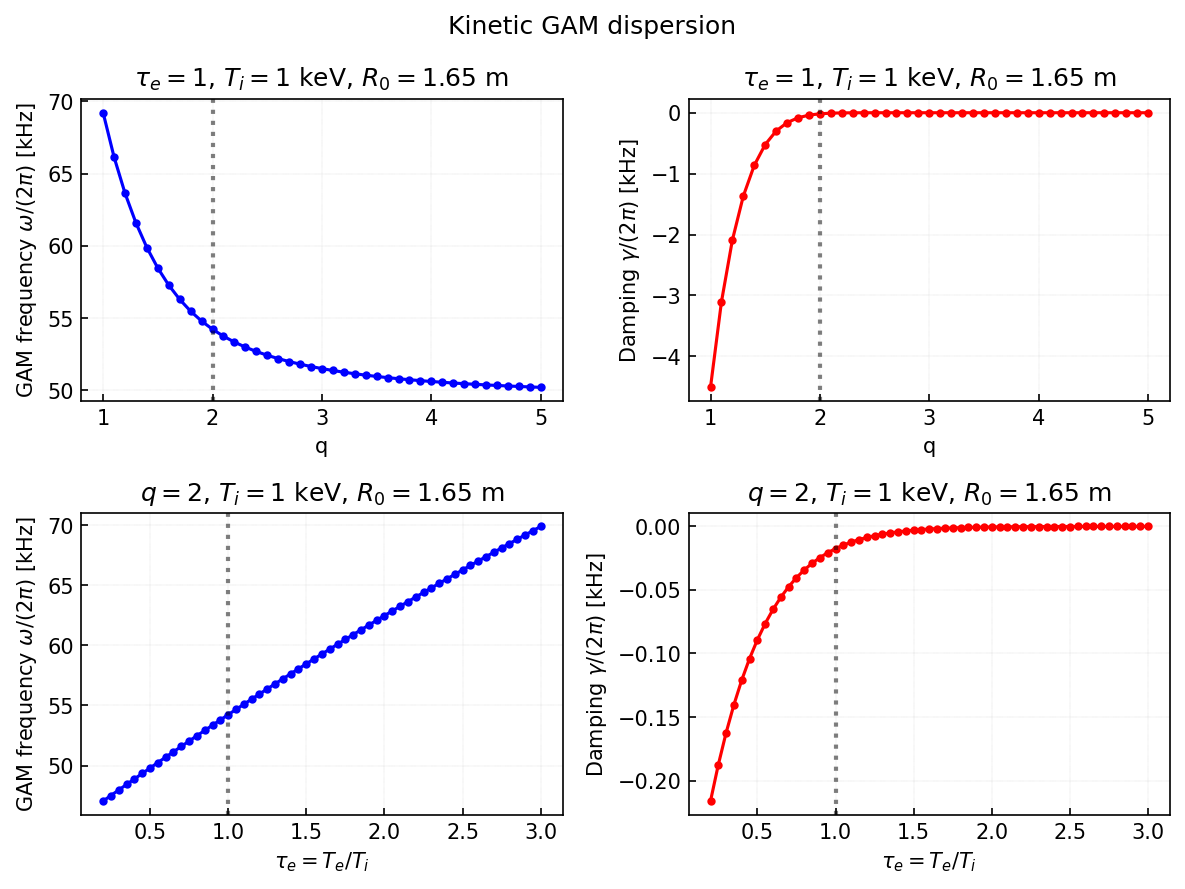

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.special import wofz

# -------------------------
# Plasma dispersion function Z(z) via Faddeeva
# -------------------------
def Z_plasma(z: complex) -> complex:
    return 1j * np.sqrt(np.pi) * wofz(z)

def F_func(z: complex) -> complex:
    Zz = Z_plasma(z)
    return z * (z**2 + 1.5) + (z**4 + z**2 + 0.5) * Zz

def N_func(z: complex) -> complex:
    Zz = Z_plasma(z)
    return z + (0.5 + z**2) * Zz

def D_func(z: complex, tau_e: float) -> complex:
    return (1.0 / z) * (1.0 + 1.0 / tau_e) + Z_plasma(z)

def dispersion(z: complex, q: float, tau_e: float) -> complex:
    return z + q**2 * (F_func(z) - (N_func(z)**2) / D_func(z, tau_e))

def solve_dispersion(q: float, tau_e: float, z0: complex = None):
    # Initial guess from fluid GAM: z_r ~ q*sqrt((7+4 tau_e)/2)
    if z0 is None:
        zr0 = q * np.sqrt((7.0 + 4.0 * tau_e) / 2.0)
        z0 = zr0 - 0.05j

    def f_real_imag(x):
        z = x[0] + 1j * x[1]
        val = dispersion(z, q=q, tau_e=tau_e)
        return np.array([val.real, val.imag])

    sol = root(f_real_imag, x0=np.array([z0.real, z0.imag]), method="hybr")
    if not sol.success:
        return None, sol
    return sol.x[0] + 1j * sol.x[1], sol

# -------------------------
# Convert to physical frequency
# ω0 = u_th,i / (q R0), u_th,i = sqrt(2 T_i / m_i)
# -------------------------
e = 1.602176634e-19
m_p = 1.67262192369e-27
m_i = 2.0 * m_p  # deuterium

def omega0_from_params(Ti_eV: float, q: float, R0_m: float) -> float:
    Ti_J = Ti_eV * e
    u_th = np.sqrt(2.0 * Ti_J / m_i)
    return u_th / (q * R0_m)

def omega_hat_from_z(z: complex, Ti_eV: float, q: float, R0_m: float) -> complex:
    return z * omega0_from_params(Ti_eV, q, R0_m)

# -------------------------
# Parameter choices (example tokamak)
# -------------------------
R0 = 1.65       # m
Ti_eV = 1000.0  # 1 keV

# -------------------------
# Scan 1: q-scan at fixed tau_e
# -------------------------
tau_e_fixed = 1.0
q_vals = np.linspace(1.0, 5.0, 41)

z_roots_q = np.full(q_vals.shape, np.nan + 1j*np.nan, dtype=complex)
omega_kHz_q = np.full(q_vals.shape, np.nan)
gamma_kHz_q = np.full(q_vals.shape, np.nan)

z_guess = None
for i, q in enumerate(q_vals):
    z_root, sol = solve_dispersion(q=q, tau_e=tau_e_fixed, z0=z_guess)
    if z_root is not None:
        z_roots_q[i] = z_root
        z_guess = z_root  # continuation
        omega_hat = omega_hat_from_z(z_root, Ti_eV=Ti_eV, q=q, R0_m=R0)
        omega_kHz_q[i] = omega_hat.real / (2*np.pi) / 1e3
        gamma_kHz_q[i] = omega_hat.imag / (2*np.pi) / 1e3

# -------------------------
# Scan 2: tau_e scan at fixed q
# -------------------------
q_fixed = 2.0
tau_vals = np.linspace(0.2, 3.0, 57)

z_roots_tau = np.full(tau_vals.shape, np.nan + 1j*np.nan, dtype=complex)
omega_kHz_tau = np.full(tau_vals.shape, np.nan)
gamma_kHz_tau = np.full(tau_vals.shape, np.nan)

z_guess = None
for i, tau_e in enumerate(tau_vals):
    z_root, sol = solve_dispersion(q=q_fixed, tau_e=tau_e, z0=z_guess)
    if z_root is not None:
        z_roots_tau[i] = z_root
        z_guess = z_root  # continuation
        omega_hat = omega_hat_from_z(z_root, Ti_eV=Ti_eV, q=q_fixed, R0_m=R0)
        omega_kHz_tau[i] = omega_hat.real / (2*np.pi) / 1e3
        gamma_kHz_tau[i] = omega_hat.imag / (2*np.pi) / 1e3

# -------------------------
# Plotting (no explicit color settings)
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=False, sharey=False, dpi=150)

# Choose the x-position(s) for the diagnostic marker.
# If you want ONE marker for all panels, set stime_diag to a single value
# and (optionally) decide which x-axis it corresponds to (q or tau_e).
#
# Example (choose ONE of these approaches):
# stime_diag = 2.0          # a vertical line at q=2.0 (for the q-panels)
# stime_diag = 1.0          # a vertical line at tau_e=1.0 (for the tau_e panels)
#
# Better: allow separate markers for q and tau_e panels:
stime_diag_q = 2.0       # marker on q-axis panels
stime_diag_tau = 1.0     # marker on tau_e-axis panels

def apply_axis_style(ax, xline=None):
    if xline is not None:
        ax.axvline(x=xline, color="k", linestyle=":", linewidth=2, alpha=0.5)
    ax.grid(True, which="both", linestyle=":", linewidth=0.2)
    ax.tick_params(axis="both", which="both", direction="in")

# (a) omega vs q
ax = axes[0, 0]
ax.plot(q_vals, omega_kHz_q, marker="o", markersize=3, linestyle="-", color='b')
ax.set_xlabel("q")
ax.set_ylabel(r"GAM frequency $\omega/(2\pi)$ [kHz]")
ax.set_title(rf"$\tau_e={tau_e_fixed:g}$, $T_i={Ti_eV/1e3:g}$ keV, $R_0={R0:g}$ m")
apply_axis_style(ax, xline=stime_diag_q)

# (b) gamma vs q
ax = axes[0, 1]
ax.plot(q_vals, gamma_kHz_q, marker="o", markersize=3, linestyle="-", color='r')
ax.set_xlabel("q")
ax.set_ylabel(r"Damping $\gamma/(2\pi)$ [kHz]")
ax.set_title(rf"$\tau_e={tau_e_fixed:g}$, $T_i={Ti_eV/1e3:g}$ keV, $R_0={R0:g}$ m")
apply_axis_style(ax, xline=stime_diag_q)

# (c) omega vs tau_e
ax = axes[1, 0]
ax.plot(tau_vals, omega_kHz_tau, marker="o", markersize=3, linestyle="-", color='b')
ax.set_xlabel(r"$\tau_e=T_e/T_i$")
ax.set_ylabel(r"GAM frequency $\omega/(2\pi)$ [kHz]")
ax.set_title(rf"$q={q_fixed:g}$, $T_i={Ti_eV/1e3:g}$ keV, $R_0={R0:g}$ m")
apply_axis_style(ax, xline=stime_diag_tau)

# (d) gamma vs tau_e
ax = axes[1, 1]
ax.plot(tau_vals, gamma_kHz_tau, marker="o", markersize=3, linestyle="-", color='r')
ax.set_xlabel(r"$\tau_e=T_e/T_i$")
ax.set_ylabel(r"Damping $\gamma/(2\pi)$ [kHz]")
ax.set_title(rf"$q={q_fixed:g}$, $T_i={Ti_eV/1e3:g}$ keV, $R_0={R0:g}$ m")
apply_axis_style(ax, xline=stime_diag_tau)

fig.suptitle("Kinetic GAM dispersion", y=0.98)
fig.tight_layout()
#plt.show()

#plt.savefig("GAM_scan.pdf", format="pdf", dpi=300, bbox_inches='tight')


# Quick sanity print at a representative point
q0, tau0 = 2.0, 1.0
z0, _ = solve_dispersion(q0, tau0)
omega0 = omega_hat_from_z(z0, Ti_eV=Ti_eV, q=q0, R0_m=R0)
print("Representative point (q=2, τe=1):")
print(f"  z = {z0.real:.6f} + i {z0.imag:.6f}")
print(f"  ω/(2π) = {omega0.real/(2*np.pi)/1e3:.3f} kHz")
print(f"  γ/(2π) = {omega0.imag/(2*np.pi)/1e3:.3f} kHz")


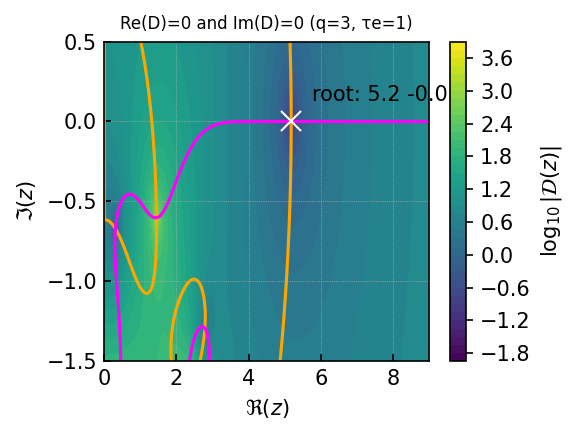

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_zero_contours(
    q=2.0, tau_e=1.0,
    re_lim=(0.0, 9.0), im_lim=(-1.5, 0.5),
    nre=450, nim=320,
    eps=1e-14, nlevels=50
):
    re = np.linspace(re_lim[0], re_lim[1], nre)
    im = np.linspace(im_lim[0], im_lim[1], nim)
    RE, IM = np.meshgrid(re, im)
    Zgrid = RE + 1j * IM

    # Evaluate dispersion on grid (vectorized if your dispersion() supports arrays;
    # otherwise keep your loop version)
    try:
        Dvals = dispersion(Zgrid, q=q, tau_e=tau_e)
    except Exception:
        Dvals = np.empty_like(Zgrid, dtype=np.complex128)
        for j in range(nim):
            row = Zgrid[j, :]
            Dvals[j, :] = np.array([dispersion(z, q=q, tau_e=tau_e) for z in row])

    zroot, _ = solve_dispersion(q=q, tau_e=tau_e)

    plt.figure(figsize=(4, 3), dpi=150)

    # --- Colormap: log10 |D| background ---
    logabs = np.log10(np.abs(Dvals) + eps)
    cf = plt.contourf(RE, IM, logabs, levels=nlevels)
    plt.colorbar(cf, label=r'$\log_{10}|\mathcal{D}(z)|$')

    # --- Zero contours on top ---
    plt.contour(RE, IM, Dvals.real, levels=[0.0], colors=['orange'])
    plt.contour(RE, IM, Dvals.imag, levels=[0.0], colors=['magenta'])

    plt.xlabel(r'$\Re(z)$')
    plt.ylabel(r'$\Im(z)$')
    plt.grid(True, which='both', linestyle=':', linewidth=0.4)
    plt.tick_params(axis='both', which='both', direction='in')
    plt.title(f'Re(D)=0 and Im(D)=0 (q={q:g}, τe={tau_e:g})', size=8)

    if zroot is not None:
        plt.plot([zroot.real], [zroot.imag], marker="x", markersize=10, color='white')
        plt.annotate(
            f"root: {zroot.real:.1f} {zroot.imag:+.1f}i",
            (zroot.real, zroot.imag),
            xytext=(10, 10),
            textcoords="offset points",
        )

    plt.xlim(re_lim)
    plt.ylim(im_lim)
    plt.tight_layout()
    plt.savefig("GAM_root.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_zero_contours(q=3.0, tau_e=1.0, re_lim=(0.0, 9.0), im_lim=(-1.5, 0.5), nre=450, nim=320)
